# Solution for Homework 4

In [44]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Copy functions from Class Notebook

In [45]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [46]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec


In [47]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [48]:
def serial_to_parallel(syms, M):
    """Convert a vector of symbols to a matrix with trailing dimension M
    
    Inputs:
    * syms - vector of information symbols
    * M - block size

    Returns:
    matrix of dimensions (*,M)
    """
    L = len(syms)
    K = L % M      # L mod M

    if K != 0:
        syms = np.append(syms, np.zeros(M-K))  # zero-padding

    return np.reshape(syms, (-1, M))           # -1 means: figure out first dimension

In [49]:
def map_to_subcarriers(block_syms, active_sc):
    """Map a matrix of symbols to active subcarriers
    
    Inputs:
    * block_syms - matrix of symbols, dimension (*,M)
    * active_sc - length N vector that marks active subcarries with 1's 

    Returns:
    matrix of dimension (*,N)
    """
    # make an array to hold the result; figure out dimensions and data type
    N = len(active_sc)
    L = block_syms.shape[0]
    res = np.zeros((L,N), dtype=block_syms.dtype)

    res[:,np.equal(active_sc, 1)] = block_syms

    return res

In [50]:
def idft(block_sc):
    """inverse DFT of matrix of symbols
    
    Inputs:
    block_sc - matrix of symbols (and empty subcarriers)

    Returns:
    matrix of the same size as the input
    """
    N_FFT = block_sc.shape[1]
    return np.fft.ifft(block_sc) * np.sqrt(N_FFT)

In [51]:
def insert_cyclic_prefix(block_sig, N_CP):
    """Insert cyclic prefix
    
    Inputs:
    block_sig - matrix of signal samples
    N_CP - length of cyclic prefix in samples

    Returns:
    signal matrix with cyclic prefix inserted; second dimension increases by N_CP
    """
    if N_CP > 0:
        return np.append(block_sig[:,-N_CP:], block_sig, axis=1)
    else:
        return block_sig

In [52]:
def parallel_to_serial(block_sig):
    """convert a matrix of signal samples into a vector
    
    Inputs:
    block_sig - matrix of signal samples

    Returns:
    vector of signal samples
    """
    return np.reshape(block_sig, -1)  # -1 means: figure out how many samples

In [53]:
class OFDM_Transmitter():
    """OFDM transmitter class
    
    Parameters:
    N_CP - length of cyclic prefix
    active_sc - length N_FFT vector marking active subcarriers

    Example:
    # create a transmitter object
    tx = OFDM_Transmitter(N_CP, active_sc) 

    # pass symbols to tx object to generate signal
    sig = tx(syms)
    """
    def __init__(self, N_CP, active):
        self.N_CP = N_CP
        self.active = active
        self.N_FFT = len(active)

        self.M = int(np.sum(active))  # number of active subcarriers

    def __call__(self, syms):
        block_syms = serial_to_parallel(syms, self.M)
        block_sc = map_to_subcarriers(block_syms, self.active)
        block_sig = idft(block_sc)
        block_sig_cp = insert_cyclic_prefix(block_sig, self.N_CP)
        return parallel_to_serial(block_sig_cp)

In [54]:
def strip_cyclic_prefix(block_sig_cp, N_CP):
    """remove the leading N_CP samples from each signal block
    
    Inputs:
    block_sig_cp - matrix of signal blocks with cyclic prefix
    N_CP - length of cyclic prefix in samples

    Returns:
    matrix of signal blocks without cyclic prefix
    """
    return block_sig_cp[:, N_CP:]

In [55]:
def dft(block_sig):
    """ DFT of matrix of signal blocks
    
    Inputs:
    block_sig - matrix of signals

    Returns:
    matrix of the same size as the input
    """
    N_FFT = block_sig.shape[1]
    return np.fft.fft(block_sig) * 1/np.sqrt(N_FFT)

In [56]:
def remove_inactive_subcarriers(block_sc, active_sc):
    """Extract symbols from active subcarriers
    
    Inputs:
    block_sc - matrix of symbols and empty subcarriers
    active_sc - length N vector that marks active subcarries with 1's 

    Returns:
    Matrix of symbols without empty subcarriers
    """
    return block_sc[:,np.equal(active_sc, 1)]

In [57]:
class OFDM_Receiver():
    """OFDM receiver class
    
    Parameters:
    N_CP - length of cyclic prefix
    active_sc - length N_FFT vector marking active subcarriers

    Example:
    # create a receiver object
    rx = OFDM_Receiver(N_CP, active_sc) 

    # pass signal to rx object to recover symbols; 
    # number of symbols to receive must be provided, unless there was no zero padding.
    syms = rx(sig, N_syms)
    """
    def __init__(self, N_CP, active):
        self.N_CP = N_CP
        self.active = active
        self.N_FFT = len(active)

        self.M = np.sum(active)  # number of active subcarriers

    def __call__(self, sig, N_syms=None):
        block_sig_cp = serial_to_parallel(sig, self.N_FFT + self.N_CP)
        block_sig = strip_cyclic_prefix(block_sig_cp, self.N_CP)
        block_sc = dft(block_sig)
        block_syms = remove_inactive_subcarriers(block_sc, self.active)
        syms = parallel_to_serial(block_syms)

        if N_syms is None:
            N_syms = len(syms)

        return syms[:N_syms]

## Problem 3

Perform a Monte Carlo simulation for an OFDM system with frequency offset.
1. Use the same parameters as in the notebook we used in class. Modify the channel to introduce a frequency offset by changing the channel from
``` Python
    # Channel
    rr = ss + np.sqrt(0.5 * 1/SNR) * (
              np.random.randn(len(ss)) +
           1j*np.random.randn(len(ss)))
```
to
``` Python
    # Channel
    rr = ss * np.exp(2j*np.pi * df/N_FFT *
                     np.arange(len(ss)))
    rr = rr + np.sqrt(0.5 * 1/SNR) * (
              np.random.randn(len(ss)) +
           1j*np.random.randn(len(ss)))
```
where `df` denotes the frequency error relative to the
subcarrier spacing. Hence, appropriate values to experiment with
are on the order of 0.01.

2. Measure and plot the symbol error rate for frequency offsets between -0.02 and 0.02.
3. Do your results change if you change the length of the cyclic prefix? 
3. Do your results change if you change the nuber of active subcarriers?
4. Can you identify the mechanism that induces the increased error rate?

**Note:** The problem is not as well posed as it should be. There are a few problems with the setup:
1. When the signal is long, i.e., consists of many OFDM symbols, then the phase error builds up over the course of the symbols. This is not an interesting thing to measure. Remedy: transmit only a single OFDM symbol at a time.
2. With the frequency error as given above, the phase will change from 0 to $2\pi \delta f$ over one symbol. Hence, we have both a frequency and a phase error. It would be better to remove the phase error by subtracting the "average" phase, i.e., $\pi \delta f$.
3. With these improvements, the frequency offsets considered should be bigger than stated. 

These improvements are used below.

In [88]:
# parameters
# 128 subcarriers with 96 of them occupied
N_FFT = 1024                      # <-- longer FFT and N_active so that we need fewer bursts
N_active = 960
active = np.ones(N_active)
active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)
N_CP = 0                          # <-- cyclic prefix not needed when there is no distortion

# channel (AWGN)
SNR_dB = 10
SNR = 10**(SNR_dB/10)

A = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2) # define a normalized QPSK constellation
N = N_active * 1                    # <-- Only one symbol per burst

# simulation parameters
max_bursts = 1000
max_errors = 400

df_vec = np.arange(-0.25, 0.252, 0.025)

# storage for results
Pe = np.zeros_like(df_vec)
sc = np.zeros_like(df_vec)

# instantiate tx and rx
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [89]:
for n in range(len(df_vec)):
    df = df_vec[n]
    N_bursts = 0
    N_errors = 0

    # the Monte Carlo loop
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = tx(sym)
        # make sure that the signal has unit energy per symbol
        ss = ss * np.sqrt(N)/np.linalg.norm(ss)
        # Channel
        rr = (ss * np.exp(2j*np.pi * df/N_FFT * (np.arange(len(ss))-len(ss)/2)) + # <-- frequency offset with zero average phase
              np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss))))
        # receiver
        Z = rx(rr)
        dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))

    Pe[n] = N_errors/(N*N_bursts)
    sc[n] = 1.96 * np.sqrt(Pe[n]*(1-Pe[n])/N/N_bursts)
    # print("df = {:4.2f}".format(df))
    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2))

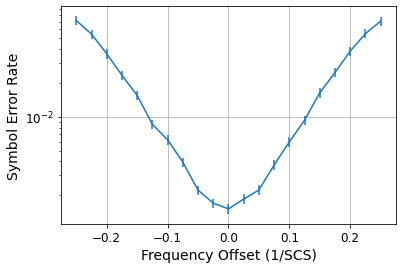

In [90]:
plt.errorbar(df_vec, Pe, sc)
plt.grid()

plt.xlabel('Frequency Offset (1/SCS)')
plt.ylabel('Symbol Error Rate')
plt.yscale('log')

plt.show()

Clearly, a frequency offset has a dramatic impact on the error rate.

Does that change when a cyclic prefix is added?

In [91]:
N_CP = N_FFT // 4                          # <-- long cyclic prefix 

# storage for results
Pe_CP = np.zeros_like(df_vec)
sc_CP = np.zeros_like(df_vec)

# instantiate tx and rx
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [96]:
for n in range(len(df_vec)):
    df = df_vec[n]
    N_bursts = 0
    N_errors = 0

    # the Monte Carlo loop
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = tx(sym)
        # make sure that the signal has unit energy per symbol
        # Note: The CP usualy incurs a penalty due to increased overhead; we remove that penalty
        # here in order to focus on the effects of frequency error
        ss = ss * np.sqrt(N)/np.linalg.norm(ss[N_CP:])
        # Channel
        rr = (ss * np.exp(2j*np.pi * df/N_FFT * (np.arange(len(ss))-len(ss)/2)) + # <-- frequency offset with zero average phase
              np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss))))
        # receiver
        Z = rx(rr)
        dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))

    Pe_CP[n] = N_errors/(N*N_bursts)
    sc_CP[n] = 1.96 * np.sqrt(Pe[n]*(1-Pe[n])/N/N_bursts)
    # print("df = {:4.2f}".format(df))
    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2))

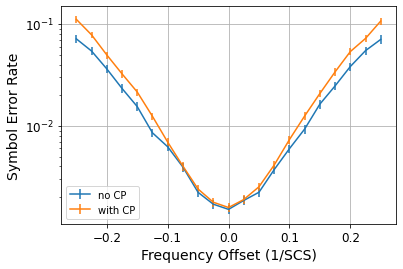

In [95]:
plt.errorbar(df_vec, Pe, sc, label="no CP")
plt.errorbar(df_vec, Pe_CP, sc_CP, label="with CP")
plt.grid()

plt.xlabel('Frequency Offset (1/SCS)')
plt.ylabel('Symbol Error Rate')
plt.yscale('log')
plt.legend()

plt.show()

The CP increase the detrimental effects of frequency error slightly. This is primarily a result of the fact that the longer OFDM symbol leads to a larger total phase change over the course of the cyclic prefix plus symbol.

What happens if the number of active subcarriers is changed?

In [98]:
N_CP = 0                          # <-- back to zero CP
N_active = 960 // 2               # <-- fewer active subcarriers
active = np.ones(N_active)
active[N_active//2 : -N_active//2] = 0 # gap in the center (maps to band-edges)

# storage for results
Pe_A = np.zeros_like(df_vec)
sc_A = np.zeros_like(df_vec)

# instantiate tx and rx
tx = OFDM_Transmitter(N_CP, active)
rx = OFDM_Receiver(N_CP, active)

In [99]:
for n in range(len(df_vec)):
    df = df_vec[n]
    N_bursts = 0
    N_errors = 0

    # the Monte Carlo loop
    while N_bursts < max_bursts and N_errors < max_errors:
        # Transmitter
        sym = random_symbols(A, N)
        ss = tx(sym)
        # make sure that the signal has unit energy per symbol
        # Note: The CP usualy incurs a penalty due to increased overhead; we remove that penalty
        # here in order to focus on the effects of frequency error
        ss = ss * np.sqrt(N)/np.linalg.norm(ss[N_CP:])
        # Channel
        rr = (ss * np.exp(2j*np.pi * df/N_FFT * (np.arange(len(ss))-len(ss)/2)) + # <-- frequency offset with zero average phase
              np.sqrt(0.5 * 1/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss))))
        # receiver
        Z = rx(rr)
        dec = MPE_decision_rule(Z, A) # Z[:N] trims extra samples from the filter transisent

        # update simulation statistics
        N_bursts += 1
        N_errors += np.sum(np.not_equal(dec, sym))

    Pe_A[n] = N_errors/(N*N_bursts)
    sc_A[n] = 1.96 * np.sqrt(Pe[n]*(1-Pe[n])/N/N_bursts)
    # print("df = {:4.2f}".format(df))
    # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*N, N_errors/(N*N_bursts)))
    # print("The exact value for the symbol error rate is: {:8.6f}".format(2*Q(np.sqrt(SNR)) - Q(np.sqrt(SNR))**2))

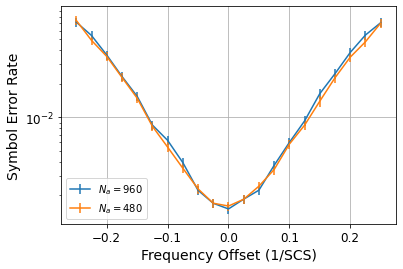

In [100]:
plt.errorbar(df_vec, Pe, sc, label="$N_a = 960$")
plt.errorbar(df_vec, Pe_A, sc_A, label="$N_a=480$")
plt.grid()

plt.xlabel('Frequency Offset (1/SCS)')
plt.ylabel('Symbol Error Rate')
plt.yscale('log')
plt.legend()

plt.show()

There is no difference between the two cases. The number of active sub-carriers does not change how susceptible an OFDM signal is to frequency offset.

What is the mechanism that leads to increased errors in the presence of frequecny offset? With frequency offset, the subcarriers are no longer orthogonal and the subcarriers begin to interfere with each other this is called inter-carrier interference (ICI).